In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [37]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Random rotations
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,  # Shear transformations
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest',
    validation_split=0.2
)


train_data = data_gen.flow_from_directory(
    'C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\dataset\\train_data',
    target_size=(224, 224),  # ResNet-50 expects 224x224 images
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale to 3 channels
    subset='training'
)

val_data = data_gen.flow_from_directory(
    'C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\dataset\\train_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

test_data = data_gen.flow_from_directory(
    'C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\dataset\\test_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [38]:
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Use dropout to add regularization
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint('C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\best_model.h5', save_best_only=True)

# Add this before model.fit()
model_checkpoint_callback = ModelCheckpoint(
    filepath='C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_learning_rate=0.0001,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[model_checkpoint_callback, reduce_learning_rate]
)

model.save('C:\\Users\\SIU856562486\\OneDrive - Southern Illinois University\\Desktop\\ResNet18\\final_ecoli_resnet_model.h5')



# Then add 'model_checkpoint_callback' to the callbacks list in model.fit()


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.6083
Epoch 1: val_loss improved from inf to 0.65378, saving model to C:\Users\SIU856562486\OneDrive - Southern Illinois University\Desktop\ResNet18\best_model.h5


C:\Users\SIU856562486\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 74s 1s/step - loss: 0.7282 - accuracy: 0.6083 - val_loss: 0.6538 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.6938
Epoch 2: val_loss improved from 0.65378 to 0.46837, saving model to C:\Users\SIU856562486\OneDrive - Southern Illinois University\Desktop\ResNet18\best_model.h5
60/60 [==============================] - 67s 1s/step - loss: 0.5325 - accuracy: 0.6938 - val_loss: 0.4684 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.7302
Epoch 3: val_loss improved from 0.46837 to 0.44311, saving model to C:\Users\SIU856562486\OneDrive - Southern Illinois University\Desktop\ResNet18\best_model.h5
60/60 [==============================] - 70s 1s/step - loss: 0.4775 - accuracy: 0.7302 - val_loss: 0.4431 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - ETA: 0s - lo

In [40]:
# Unfreeze some of the base model layers
base_model.trainable = True
fine_tune_at = 100  # This is the number of layers from the top to fine-tune

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,  # Continue for more epochs
    callbacks=[model_checkpoint_callback, reduce_learning_rate]
)


Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 1.0736 - accuracy: 0.8167
Epoch 1: val_loss did not improve from 0.19078
60/60 [==============================] - 145s 2s/step - loss: 1.0736 - accuracy: 0.8167 - val_loss: 3.4277 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9094
Epoch 2: val_loss did not improve from 0.19078
60/60 [==============================] - 130s 2s/step - loss: 0.2393 - accuracy: 0.9094 - val_loss: 1.7972 - val_accuracy: 0.4833 - lr: 1.0000e-05
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9281
Epoch 3: val_loss did not improve from 0.19078
60/60 [==============================] - 129s 2s/step - loss: 0.1828 - accuracy: 0.9281 - val_loss: 5.4635 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/25
60/60 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9271
Epoch 4: val_loss did not improve from 0.1

In [41]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

# Predict on the test set
predictions = (model.predict(test_data) > 0.5).astype(int).flatten()

# True labels
true_labels = test_data.classes

# Detailed metrics
conf_matrix = confusion_matrix(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

18/18 [==============================] - 17s 934ms/step - loss: 0.1249 - accuracy: 0.9643
Test accuracy: 0.9643, Test loss: 0.1249
18/18 [==============================] - 17s 848ms/step
Precision: 0.9571, Recall: 0.9571, F1 Score: 0.9571, Accuracy: 0.9571


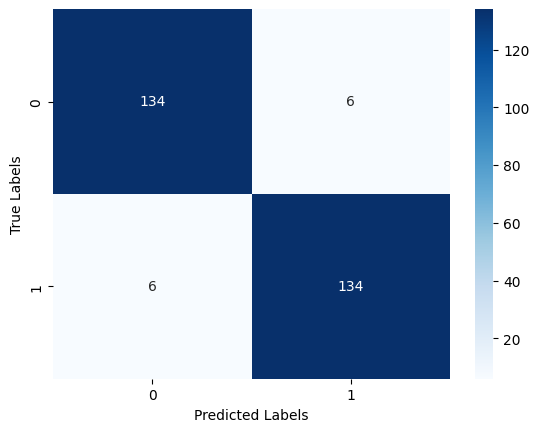

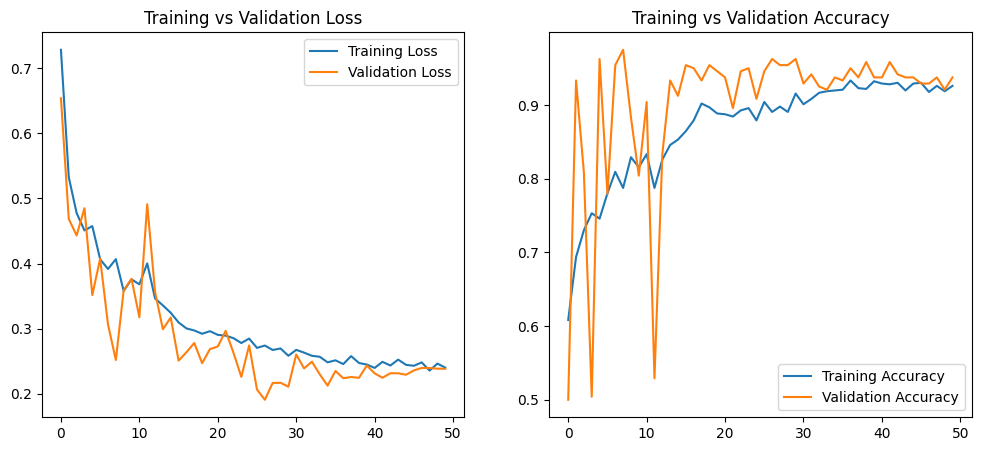

In [42]:
# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()